(nonlinearity:solution)=
### Von-May function

Write a function which solves the Von-May-Equation.


#### Problem description:

<blockquote>The starting point for our analysis is the ‘Von-May-Equation’, which is given by <br>

    
**\begin{align}    
y_{t+1} = r \cdot y_{t} \cdot (1-y_{t}),
\end{align}**

with  $r$ an pre-defined parameter and $y$ the function value at time $t$ and $t+1$.</blockquote>

In [1]:
import matplotlib.pyplot as plt

def von_may(y0,r):
    '''
    This function integrates the Von-May Equationn using a then initial condition y0, 
    and the parameter r
    '''

    # Assignments
    yi = y0    
    result = [yi]

    # Integrate over 50 time steps
    for t in range(500):
        y = r*yi*(1-yi)    # Von-May-Gleichung
        yi = y             # Store new values for next step
        result.append(y)   # Append the y-value to the result list

    return(result)



Run the code for several initial and parameter combination. What is particularly striking about increasing r-values?


```
y(0)=0.5 and r=2.80 (alternatively, use y(0)=0.9) 
y(0)=0.5 and r=3.30 (alternatively, use y(0)=0.9) 
y(0)=0.5 and r=3.95 (alternatively, use y(0)=0.495) 
y(0)=0.8 and r=2.80 

```

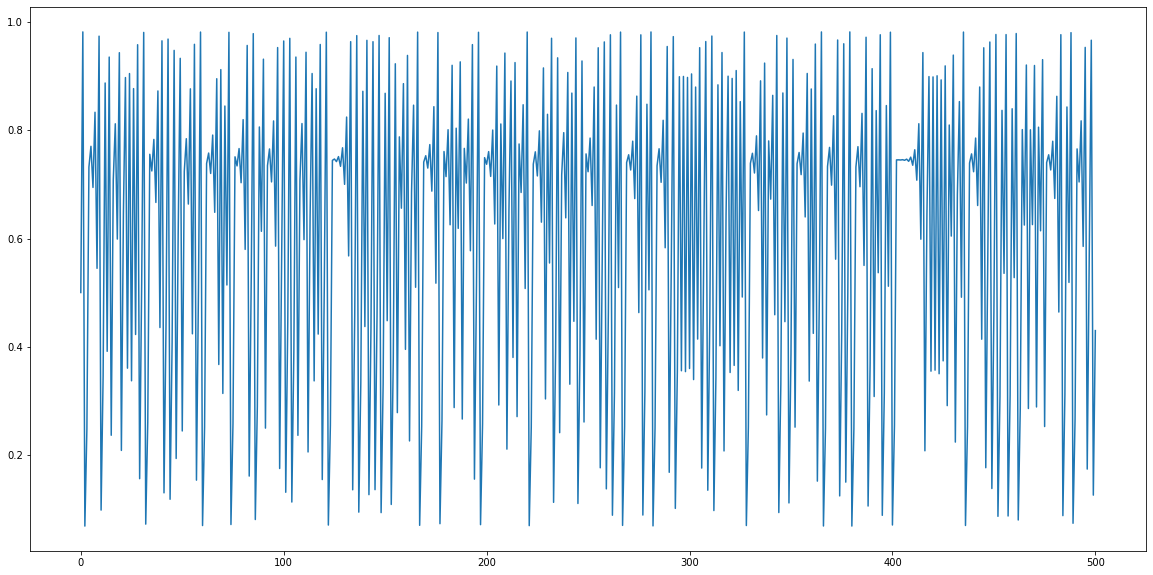

In [2]:
# Integrate the equation
res = von_may(0.5, 3.93)

# Plot the equation
plt.figure(figsize=(20,10))
plt.plot(res)

### Extend the Von-May function
Extend this Von-May function by generating 20 random r-values and run simulations with them. Sample the values from a normal distribution with mean 3.95 and standard deviation 0.015 (limit the r-values between 0 and 4). Then average over all time series. Plot both the time series, the averaged time series and the histogram of the averaged time series. What do you observe?

In [3]:
import random
import numpy as np

def ensemble_may(n, y0, r):
    '''
    The function runs n ensemble members of the Von-May-Equation. The function takes the 
    initial condition y0, the parameter r, and the number of ensemble members n.

    Example: ensemble(50, 0.5, 3.95)

    Author: Tobias Sauter
    Date:   07/04/2022

    '''

    # Assignments     
    result = []
    random.seed()
    # Generate ensemble members
    for ens_member in range(n):
        
        # Generate random parameter r
        rnd = random.normalvariate(r,0.02)
        if rnd<=0 or rnd>4:
            # set constraints for the random number 0<rnd<4
            while rnd<=0 or rnd>4:
                rnd = random.normalvariate(r,0.02);
                
        # Integrate the equation
        result.append(von_may(y0,rnd))
        
        
    return(result)



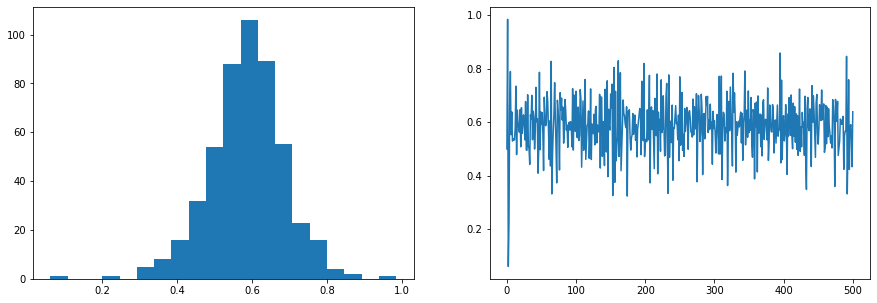

In [4]:
ens = ensemble_may(10, 0.5, 3.93)
ens_mean = np.mean(np.array(ens),axis=0)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(ens_mean, 20)
ax[1].plot(ens_mean)

## Revisit the EBM-Model

#### Include a dynamic transmissivity in the energy balance model.

Run the energy balance model $T(0)=288 ~ K$, $C_w= 2\cdot10^8 ~ J/(m^2
 57 \cdot K)$, $\alpha=0.3$, and $\tau_{mean}=0.608 (\pm 1\%)$

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt


def OLR(T, tau):
    """ Stefan-Boltzmann law """
    sigma = 5.67e-8
    return tau * sigma * T**4

def ASR(Q, alpha):
    """ Absorbed shortwave radiation """
    return (1-alpha) * Q


def step_forward(Q, T, Cw, alpha, tau, dt):
    return T + dt / Cw * ( ASR(Q, alpha) - OLR(T, tau) )


def ebm_stochastic(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.64, years=100):
    ''' This is a simple Energy Balance Model with global radiation and outgoing longwave radiation.'''
  
    # Create result arrays
    Ts    = np.zeros(years+1)
    Years = np.zeros(years+1)
    
    # Timestep
    dt = 60*60*24*365                  # convert days to seconds

    # Initial and boundary conditions
    Ts[0] = T0 

    # Calculation
    for n in range(years):
        tau_rnd = random.normalvariate(tau,tau*0.01)
        Years[n+1] = n+1
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha, tau_rnd, dt )
        
    return Years, Ts
        

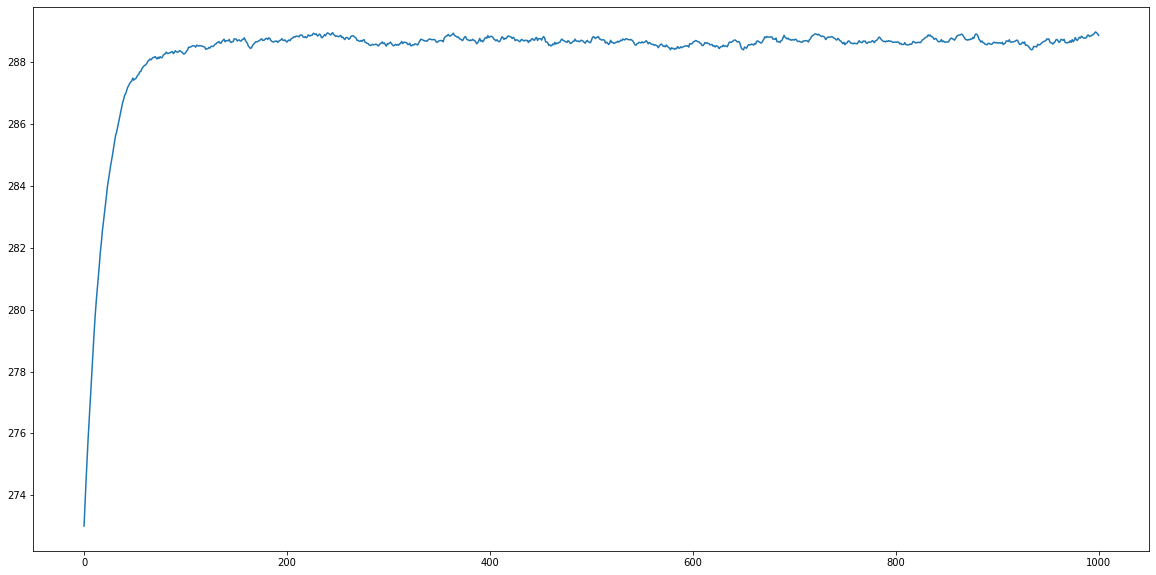

In [6]:
yrs, Ts = ebm_stochastic(273, Q=342, Cw=2*10e8, alpha=0.30, tau=0.608, years=1000)

fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(yrs,Ts)

#### Extend the model with a simple ice/land use albedo parameterisation. 

In this parameterisation, the albedo is solely a function of mean temperature. As a non-linear function we assume a sigmoid function with

\begin{align}
\alpha(T_i) = 0.3 \cdot (1-0.03 \cdot \tanh(1.548 \cdot (T_i-288))).
\end{align}

Run the energy balance model for 100 years with four different initial conditions for T(0)=286.0, 288.6, 288.9, and 293.0 K, while fixing the other parameters to $C_w$= 2$\cdot10^8$ J/(m$^2 \cdot$ K), $\alpha$=0.3, and $\tau_{mean}$=0.608. 

What can be said about the state of equilibrium?

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt


def OLR(T, tau):
    """ Stefan-Boltzmann law """
    sigma = 5.67e-8
    return tau * sigma * T**4

def ASR(Q, alpha):
    """ Absorbed shortwave radiation """
    return (1-alpha) * Q


def step_forward(Q, T, Cw, alpha, tau, dt):
    return T + dt / Cw * ( ASR(Q, alpha) - OLR(T, tau) )


def ebm_ice_albedo(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.64, years=100):
    ''' This is a simple Energy Balance Model with global radiation and outgoing longwave radiation.'''
  
    # Create result arrays
    Ts    = np.zeros(years+1)
    Years = np.zeros(years+1)
    
    # Timestep
    dt = 60*60*24*365                  # convert days to seconds

    # Initial and boundary conditions
    Ts[0] = T0 

    # Calculation
    for n in range(years):
        alpha_adapt = alpha * (1 - 0.03 * np.tanh(1.548*(Ts[n]-288.67)))
        Years[n+1] = n+1
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha_adapt, tau, dt )
        
        
    return Years, Ts

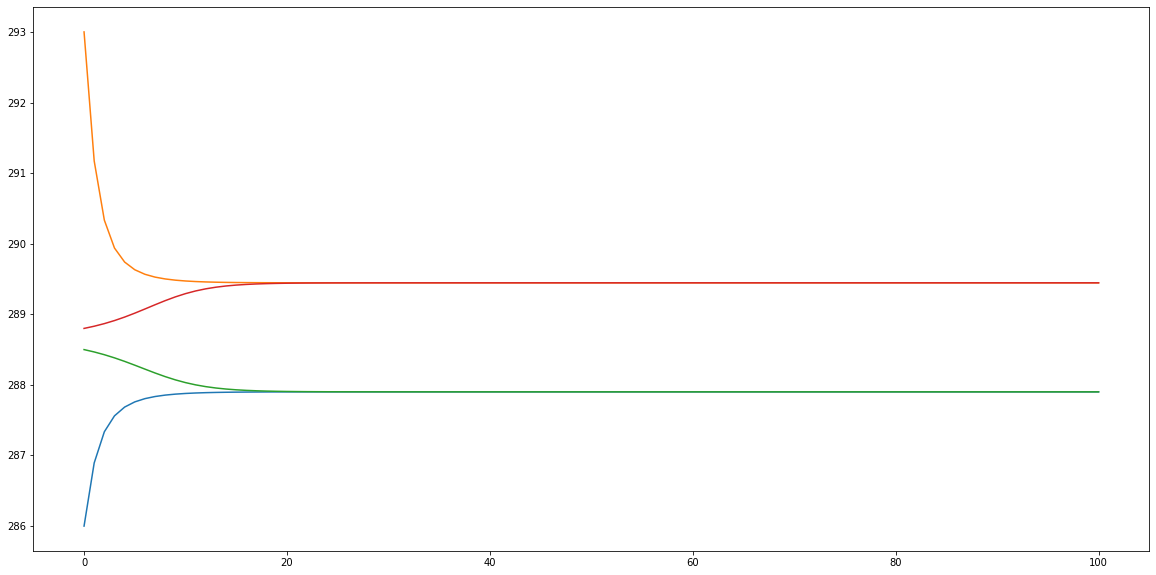

In [8]:

yrs, Ts286 = ebm_ice_albedo(286, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=100)
yrs, Ts293 = ebm_ice_albedo(293, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=100)
yrs, Ts288_6 = ebm_ice_albedo(288.5, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=100)
yrs, Ts288_9 = ebm_ice_albedo(288.8, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=100)


fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(yrs, Ts286)
ax.plot(yrs, Ts293)
ax.plot(yrs, Ts288_6)
ax.plot(yrs, Ts288_9)

#### Repeat the previous simulation, but again sample the transmissivity on a normal distribution with a standard deviation of 3%.  
What special feature can now be observed? What conclusions can be inferred regarding the prediction of
weather and climate?


In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt


def OLR(T, tau):
    """ Stefan-Boltzmann law """
    sigma = 5.67e-8
    return tau * sigma * T**4

def ASR(Q, alpha):
    """ Absorbed shortwave radiation """
    return (1-alpha) * Q


def step_forward(Q, T, Cw, alpha, tau, dt):
    return T + dt / Cw * ( ASR(Q, alpha) - OLR(T, tau) )


def ebm_ice_albedo_stochastic(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.64, years=100):
    ''' This is a simple Energy Balance Model with global radiation and outgoing longwave radiation.'''
      
    # Timestep
    dt = 60*60*24*365                  # convert days to seconds
    integration = int((365/10)*years)
    
    # Create result arrays
    Ts    = np.zeros(years+1)
    Years = np.zeros(years+1)
    
    # Initial and boundary conditions
    Ts[0] = T0 

    # Calculation
    for n in range(years):
        alpha_adapt = alpha * (1 - 0.03 * np.tanh(1.548*(Ts[n]-288.67)))
        tau_rnd = random.normalvariate(tau,tau*0.01)
        Years[n+1] = n+1
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha_adapt, tau_rnd, dt )
        
        
    return Years, Ts

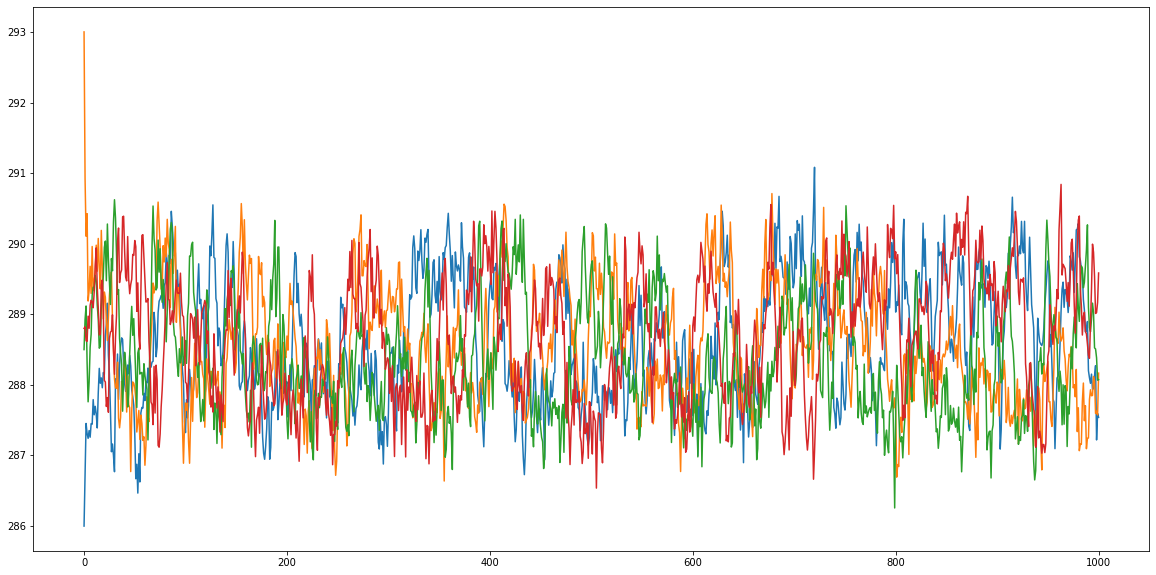

In [10]:
yrs, Ts286 = ebm_ice_albedo_stochastic(286, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=1000)
yrs, Ts293 = ebm_ice_albedo_stochastic(293, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=1000)
yrs, Ts288_6 = ebm_ice_albedo_stochastic(288.5, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=1000)
yrs, Ts288_9 = ebm_ice_albedo_stochastic(288.8, Q=342, Cw=2*10**8, alpha=0.30, tau=0.608, years=1000)


fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(yrs, Ts286)
ax.plot(yrs, Ts293)
ax.plot(yrs, Ts288_6)
ax.plot(yrs, Ts288_9)

(array([ 1.,  0.,  2.,  4.,  8., 14., 31., 37., 63., 69., 56., 78., 90.,
        60., 64., 64., 57., 40., 30., 41., 38., 28., 37., 22., 21., 17.,
         7., 14.,  5.,  3.]),
 array([286.25685524, 286.40239288, 286.54793053, 286.69346818,
        286.83900583, 286.98454347, 287.13008112, 287.27561877,
        287.42115641, 287.56669406, 287.71223171, 287.85776935,
        288.003307  , 288.14884465, 288.29438229, 288.43991994,
        288.58545759, 288.73099523, 288.87653288, 289.02207053,
        289.16760818, 289.31314582, 289.45868347, 289.60422112,
        289.74975876, 289.89529641, 290.04083406, 290.1863717 ,
        290.33190935, 290.477447  , 290.62298464]),
 <BarContainer object of 30 artists>)

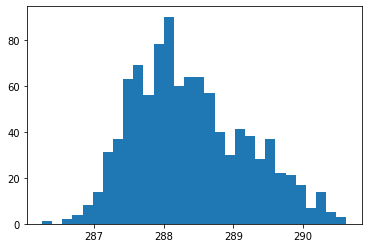

In [11]:
plt.hist(Ts288_6,30)